# **ExpLogic**

### **Setting up**

#### **Dependencies**

In [73]:
# System Utilities
import os
import time
import copy
import random
import pickle
import importlib as lib
from collections import defaultdict

# Data Processing
import numpy as np
import pandas as pd
import yaml

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset

# Image Processing
import cv2
import matplotlib.pyplot as plt
from matplotlib import rc
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda

# Dataset Utilities
from utils import mnist_dataset
from utils import subset_loaders as subset
from utils import data_getter as dat

# Metrics and Analysis
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

# DiffLogic and Logic Graph
from difflogic import LogicLayer, GroupSum, PackBitsTensor
from utils import LogicGraph as lg

# Configuration Management
from hydra import initialize, compose

# Check GPU Availability
print(f"Available GPUs: {torch.cuda.device_count()}")

Available GPUs: 4


#### **Dataset**

Tunable Variables

In [74]:
# Configurable options
crop          = None             # (x,x) else None: Removes border of Mnist, False: Keeps black border around digits
dataset_name  = "fashion_mnist"  # "mnist"/"fashion_mnist" 
bpp           = 1                # Bits-Per-Pixels (fixed at 1 for ExpLogic for the binary case) 

Set Seed for Reproducibiity

In [75]:
torch.manual_seed(42)      # PyTorch seed fixing
torch.cuda.manual_seed(42) # PyTorch CUDA seed fixing (if using GPU)
np.random.seed(42)         # NumPy seed fixing
random.seed(42)            # Python's built-in random seed fixing

Dataset Transform

In [76]:
batch_size = 512
train_loader, test_loader, input_dim, out_dim = dat.get_dataset(dataset_name, batch_size=batch_size, data_dir='./data', bpp=bpp, crop=crop)

In [77]:
# makes the Dataset evenly partitioned
# code below is used so that all classes have the same number of samples
train_targets = train_loader.dataset.targets
test_targets = test_loader.dataset.targets

train_digits_total = []
test_digits_total = []

for i in range(10):
    curr_tot_train = torch.sum(train_targets == i).item()
    curr_tot_test = torch.sum(test_targets == i).item()    
    train_digits_total.append(curr_tot_train)
    test_digits_total.append(curr_tot_test)

train_digits_total, test_digits_total

# find the minimum number of samples across all classes
min_samples_train = min(train_digits_total)
min_samples_test = min(test_digits_total)

# function to trim dataset to match the minimum samples for each class and shuffle indices
def trim_dataset(dataset, targets, min_samples):
    indices = []
    for i in range(10):
        class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
        class_indices = class_indices[:min_samples]  # trim to min_samples
        indices.extend(class_indices)

    # shuffle indices after collecting them
    indices = torch.tensor(indices)
    indices = indices[torch.randperm(indices.size(0))]  

    return Subset(dataset, indices)

# trim both train and test datasets to ensure all classes have the same number of samples
trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

# create DataLoaders for the trimmed datasets
trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

# verify the lengths of the trimmed datasets
len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

train_dataset = trimmed_train_dataset
test_dataset = trimmed_test_dataset
train_loader = trimmed_train_loader
test_loader = trimmed_test_loader

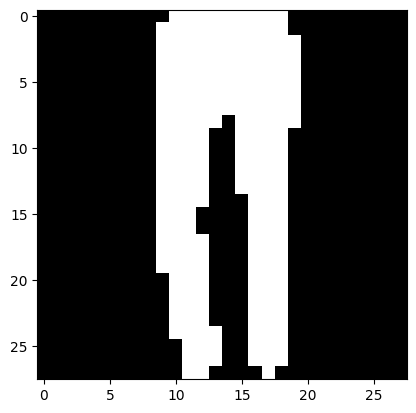

In [78]:
# visualizing a single image
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)
image        = np.array(train_loader.dataset[random_index][0])
shape        = (20,20) if crop else (28,28)
image        = np.array([np.sum([image[(j*bpp) + p]*(2**(bpp-p+1)) for p in range(bpp)]) for j in range(shape[0]*shape[0])]).reshape(shape)

plt.figure()
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [79]:
# define first input and the name of the file to be saved
if dataset_name == "mnist":
    first_in_dim = 400*bpp
    filename = "config/mnist_config_20x20.yaml"
    df = pd.read_csv("config/mnist_hyperparameters.csv")
elif dataset_name == "fashion_mnist":
    first_in_dim = 784*bpp
    filename = "config/fashion_mnist_config_28x28.yaml"
    df = pd.read_csv("config/fashion_mnist_hyperparameters.csv")

In [80]:
# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/fashion_mnist_config_28x28.yaml' generated successfully.


### **Model Definition**

#### **Model Function Declarations**

DiffLogic Class

In [81]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        #x = torch.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs.float())

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [82]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

### **Model Training/Testing**

#### **Training**

In [15]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="ExpLogic"):
    cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")

# training loop for all models
all_models_dict = {}
num_epochs = 1 # just for debugging
file_path = f'trained_models/{dataset_name}_trained_models' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    # initializes DiffLogic model and moves to CUDA if available
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                      output_size=model_cfg['output_size'], 
                      tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

    # wraps the model with DataParallel to distribute workload across GPUs 
    #model = torch.nn.DataParallel(model)
    
    # optimizer and loss criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # early stopping
    early_stopper = EarlyStopper(patience=5)

    print('model', model)

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
        epoch_loss = 0  # to track loss for an epoch            

        for batch_inputs, batch_outputs in loop:
            # move data to the appropriate device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

            # forward pass through the model
            predictions = model(batch_inputs)  
                        
            loss = criterion(predictions, batch_outputs)
            
            # zero gradients, backpropagates, and updates model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # accumulating the loss for the epoch
            epoch_loss += loss.item()

        # caclulating the average loss for the epoch
        epoch_loss /= len(train_loader)
        all_models_dict[model_name]['losses'].append(epoch_loss)
        print(f'Epoch {epoch+1} Loss: {epoch_loss}')

        # checks for early stopping
        if early_stopper.should_stop(epoch_loss):
            print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
            break

    # saving trained model's state
    model.save(file_path, model_name)

print("All models processed.")

training model model_001
LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(784, 5000, train)
    (1): LogicLayer(5000, 5000, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/1: 100%|██████████| 117/117 [01:55<00:00,  1.01it/s]

Epoch 1 Loss: 1.4403667081375555
All models processed.


#### **Testing**

In [17]:
# testing loop to test inferences
trained_models_dir = f'trained_models/{dataset_name}_trained_models/'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")

# dictionary to store the trained models
trained_models = {}
trained_models_accuracies = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    if model_name in cfg['models'].keys(): 
        model_cfg = cfg['models'][model_name]

        # instantiates the model and load its weights
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                              output_size=model_cfg['output_size'], 
                              tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

        model_path = os.path.join(trained_models_dir, model_file)
        print(f"Evaluating {model_file}...")

        # loads the respective model
        model.load(model_path)

        # calculates accuracy
        accuracy = model.get_accuracy(test_loader)

        print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")

        trained_models[i] = model
        trained_models_accuracies[i] = accuracy

LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]

Accuracy of model_001.pth: 82.31%



### **Switching Probability**

Loading a specific model, mainly so that you can load the model without having to run inference

In [22]:
model_name = 'model_001'

In [23]:
trained_models_dir = f'trained_models/{dataset_name}_trained_models/'

with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    model_cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")

model_cfg = model_cfg['models'][model_name]

model = DiffLogic(layers_config=model_cfg['layers_config'], 
    output_size=model_cfg['output_size'], 
    tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')    

model_path = os.path.join(trained_models_dir, model_name + ".pth")
model.load(model_path)

LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)


Converting DiffLogic to LogicGraph

In [24]:
lg = lib.reload(lg)

print("Creating LogicGraph")
gall = lg.LogicGraph(model)

gall.compute_sf(test_loader)
gall.compute_sp(np.ones((shape[0],shape[1]))-0.5)

# Example of accessing the gate type per edge
#gall.edges()[('L1_N576', 'L2_N1210')]["ab"]

Creating LogicGraph


Processing images: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


#### **Difference of SP for Individual Classes**

Find the TP, TN, FP, FN instances, and use this to create sub-datasets for specific cases 
(NOTE: This section will take some time to run)

If you get stuck trying to run the following, restart the kernel and set "saved" to True

In [25]:
saved = False  # Set to True after the first successful run

# Define file paths for saving data
train_data_file = "train_data.pkl"
test_data_file = "test_data.pkl"

# Function to save data
def pkl_save(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

# Function to load data
def pkl_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def predict_and_categorize(model, data_loader):
    all_images      = []
    all_labels      = []
    all_predictions = []

    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_inputs, batch_outputs in tqdm(data_loader, desc="Predicting"):
            batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

            # Forward pass to get predictions
            outputs = model(batch_inputs.float())

            # Get the predicted class (index of the maximum logit)
            _, predicted = torch.max(outputs.data, 1)

            all_images.append(batch_inputs.cpu())
            all_labels.append(batch_outputs.cpu())
            all_predictions.append(predicted.cpu())

    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    return all_images, all_labels, all_predictions

# Check if data is already saved
if saved and os.path.exists(train_data_file) and os.path.exists(test_data_file):
    print("Loading saved datasets...")
    train_data = pkl_load(train_data_file)
    test_data = pkl_load(test_data_file)
    all_images_train, all_labels_train, all_predictions_train = train_data
    all_images_test, all_labels_test, all_predictions_test = test_data
    print("All datasets loaded.")
else:
    print("Processing datasets...")
    # Predict and categorize
    all_images_train, all_labels_train, all_predictions_train = predict_and_categorize(model, train_loader)
    all_images_test, all_labels_test, all_predictions_test = predict_and_categorize(model, test_loader)
    
    # Save the results for future use
    pkl_save((all_images_train, all_labels_train, all_predictions_train), train_data_file)
    pkl_save((all_images_test, all_labels_test, all_predictions_test), test_data_file)
    saved = True

Processing datasets...


Predicting: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


In [26]:
# Create TN/TP/FN/FP datasets
general_datasets        = subset.create_tn_tp_fn_fp_datasets(all_images_train, all_labels_train, all_predictions_train)
class_specific_datasets = subset.create_class_specific_datasets(all_images_train, all_labels_train, all_predictions_train)

In [27]:
# For the general TN, TP, FN, FP datasets:
t_dataset = DataLoader(general_datasets['T'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
f_dataset = DataLoader(general_datasets['F'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# For class-specific datasets (e.g., for class 5):
for i in range(10): 
    class_specific_datasets['TP_class'][i] = DataLoader(class_specific_datasets['TP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['FP_class'][i] = DataLoader(class_specific_datasets['FP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['TN_class'][i] = DataLoader(class_specific_datasets['TN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['FN_class'][i] = DataLoader(class_specific_datasets['FN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

Class Specific Differences

(This may take a substantial amount of time)

In [28]:
# Create class-specific data loaders for training and testing sets
train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size)
test_class_loaders  = subset.create_class_dataloaders(test_dataset,  batch_size)

In [30]:
outputs = [f"L3_N0", f"L3_N1", f"L3_N2", f"L3_N3", f"L3_N4", f"L3_N5", f"L3_N6", f"L3_N7", f"L3_N8", f"L3_N9"]

p_maps = []
sp_graphs = [] 
sp_diffs = []  
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"averaged_images/{dataset_name}_averages/average_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))

In [31]:
# Compute SF for each graph (each class)
graphs = {}
for g in range(10): 
    print(f"Class {g}")
    graphs[g] = lg.LogicGraph(model)
    graphs[g].compute_sf(train_class_loaders[g])

Class 0


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Class 1


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Class 2


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Class 3


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Class 4


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Class 5


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Class 6


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Class 7


Processing images: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Class 8


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Class 9


Processing images: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


In [32]:
# Compute FPS, TPS, FNS and TNS for each graph
fps = {}
tps = {}
fns = {}
tns = {}
for g in range(10): 
    print(g)
    fps[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['FP_class'][g]] != []:
        fps[g].compute_sf(class_specific_datasets['FP_class'][g])
    #tps[g] = LogicGraph(model)
    #if [i for i in class_specific_datasets['TP_class'][g]] != []:
    #    tps[g].compute_sf(class_specific_datasets['TP_class'][g])
    fns[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['FN_class'][g]] != []:
        fns[g].compute_sf(class_specific_datasets['FN_class'][g])
    tns[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['TN_class'][g]] != []:
        tns[g].compute_sf(class_specific_datasets['TN_class'][g])

0


Processing images: 100%|██████████| 102/102 [00:10<00:00,  9.93it/s]


1


Processing images: 100%|██████████| 105/105 [00:10<00:00,  9.91it/s]


2


Processing images: 100%|██████████| 102/102 [00:10<00:00,  9.86it/s]


3


Processing images: 100%|██████████| 103/103 [00:10<00:00,  9.84it/s]


4


Processing images: 100%|██████████| 102/102 [00:10<00:00,  9.80it/s]


5


Processing images: 100%|██████████| 103/103 [00:10<00:00,  9.76it/s]


6


Processing images: 100%|██████████| 102/102 [00:10<00:00,  9.70it/s]


7


Processing images: 100%|██████████| 104/104 [00:10<00:00,  9.71it/s]


8


Processing images: 100%|██████████| 104/104 [00:10<00:00,  9.67it/s]


9


Processing images: 100%|██████████| 104/104 [00:10<00:00,  9.63it/s]


In [33]:
# Compute SF Diff for each combination
print("Computing diffs")
diffs = {}
for i in range(10): 
    diff = {} 
    for j in range(10): 
        diff[j] = graphs[i] - graphs[j]
    diffs[i] = diff

print("Computing centered")
centered = {}
for i in range(10): 
    centered[i] = graphs[i] - gall
    
print("Computing specific")
specific = {}
for i in range(10): 
    specific[i] = graphs[i] - tns[i]    

Computing diffs
Computing centered
Computing specific


##### **Visualizations**

Initialize helper functions for visualizing the FAN-IN

In [34]:
a_not_list = ["not_implied_by", "not_or","not_xor","not_a","implies","not_and"]
b_not_list = ["not_implies", "not_or","not_xor","not_b","implied_by","not_and"]

def find_fan_in(G, output_node, threshold,metric="sf"):
    """
    Find all input nodes connected to the given output node.
    """
    fan_in = set()
    nodes_to_check = [(output_node,1)]
    input_set = []
    while nodes_to_check:
        
        # Get node and node properties 
        parent_node, dpo = nodes_to_check.pop(0)
        new_fan_in  = []
        child_gates = []
        parent_type = G.nodes[parent_node]["gate"]
        
        # Account for all predesesors
        for child_node in list(G.predecessors(parent_node)): 
            
            desired_parent_output = dpo*1
            
            # Get type of child node 
            child_type = G.nodes[child_node]["gate"]
            
            # Account for output case 
            if parent_type == "output": 

                # Check whether the current node is contributing to the class output
                desired_child_output = desired_parent_output
                if G.nodes[child_node][metric] > threshold: 
                    child_gates.append((child_node, desired_child_output))
                    new_fan_in.append((child_node,  desired_child_output))

            # Account for hidden-layer case 
            elif child_node != "input": 

                # Get the current wire type
                props     = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    desired_child_output = -desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] <= threshold: # Less than because we contribute by being a zero 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    desired_child_output = desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] > threshold: 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))

            # Account for input case
            else: 
                
                # Get the current wire type
                props = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    child_sign = -1*parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    child_sign = parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                        
        fan_in.update(new_fan_in)
        nodes_to_check.extend(child_gates)

    return fan_in, input_set

def node_to_pixel(node_id):
    """
    Convert a node ID (e.g., 'L0_Gate 1') to pixel coordinates.
    Assumes the input layer corresponds to a 28x28 image (MNIST format).
    """
    if (node_id != "HIGH") and (node_id != "LOW"): 
        layer, gate = node_id.split('_')
        
        gate_num = int(gate.split("N")[1]) - 1  # Convert 'Gate X' to zero-based index

        if layer == 'L0':  # Input layer
            y = gate_num // shape[1]
            x = gate_num % shape[0]
            return (x, y)
        
    return None  # For non-input layers, return None

def visualize_fan_in(G, output_node,threshold,signed=True, show=False,metric="sf"):
    """
    Visualize the fan-in of the given output node as highlighted pixels in an image.
    """
    fan_in,pixels = find_fan_in(G, output_node,threshold,metric)
    # Create a blank 28x28 image
    img = np.zeros(shape)
    
    # Highlight pixels corresponding to input nodes in the fan-in
    for node,sign in fan_in:
        pixel = node_to_pixel(node)
        if pixel:
            x, y = pixel
            if signed: 
                img[y, x] += sign  # Set pixel to white (1)
            else: 
                img[y, x] += 1  # Set pixel to white (1)

    if show: 
        # Plot the image
        plt.imshow(img)
        plt.title(f"Fan-in visualization for {output_node}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
    
    return img, fan_in,pixels

Visualize the saliency maps for the FAN-IN (Class specific SF, and Global SF)

#################################################### Switch Probability ####################################################
--- Uniform 0.5


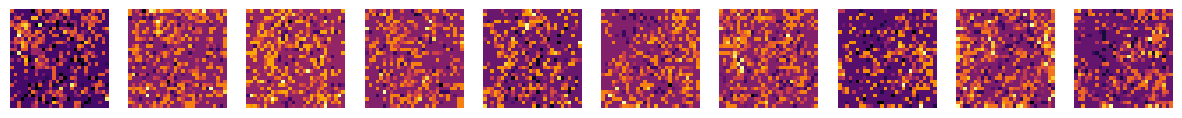

--- Average of All Images


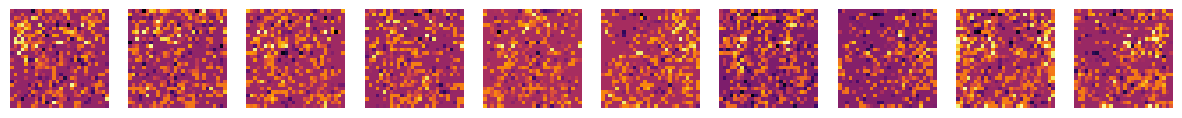

--- Average of Class-Specific Images


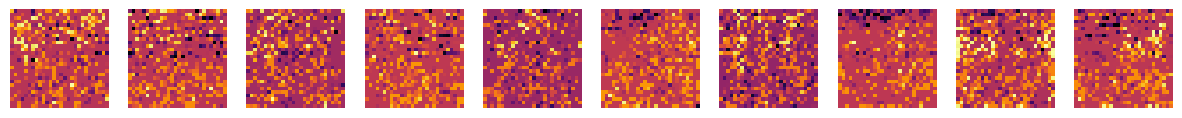

--- (Class-Specific) - (Global Average)


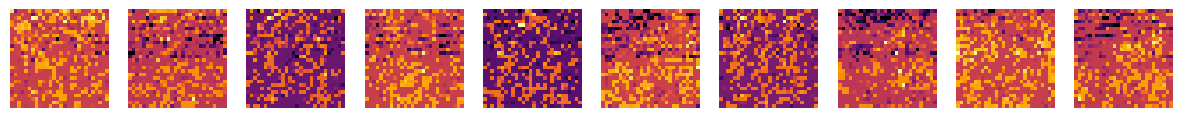

#################################################### Switch Frequency ####################################################
--- (Signed Association)


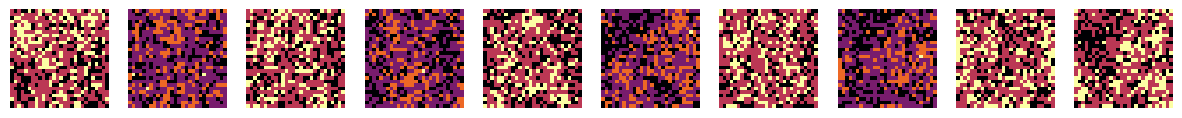

--- (All Data)


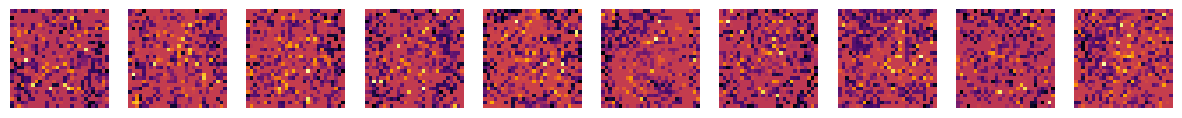

--- (Class-Specific)


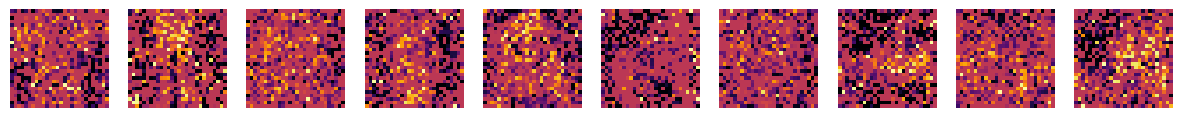

--- (Class-Specific) - (All Data)


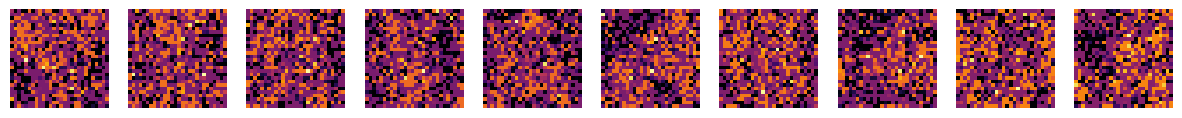

In [39]:
# Configuration
thresholds_uniform = [float(i) / 100 for i in range(100)]
thresholds_offset = [float(i) / 100 - 0.5 for i in range(100)]
outputs = [f"L3_N{i}" for i in range(10)]  # Modify as needed for your dataset
test = True

# Helper Functions
def load_class_averages(dataset_name, num_classes, shape):
    """Load class-specific average images."""
    p_maps = []
    for class_idx in range(num_classes):
        img_path = f"averaged_images/{dataset_name}_averages/average_{class_idx}.png"
        image = cv2.imread(img_path)[4:24, 4:24, 1] / 255  # Crop and normalize
        p_maps.append(image)
    return p_maps

def compute_graphs(graph, p_maps):
    """Compute graphs and differences for class-specific averages."""
    sp_graphs = []
    sp_diffs = []
    for p_map in p_maps:
        sp_graph = copy.deepcopy(graph)
        sp_graph.compute_sp(p_map)
        sp_graphs.append(sp_graph)
        sp_diffs.append(sp_graph.sub_sp(graph))
    return sp_graphs, sp_diffs

def plot_images(images, titles=None, figsize=(15, 10), cmap="inferno"):
    """Plot a row of images."""
    fig, ax = plt.subplots(1, len(images), figsize=figsize)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap=cmap)
        ax[i].set_axis_off()
        if titles:
            ax[i].title.set_text(titles[i])
    plt.show()

def plot_row(graphs, thresholds, signed, metric, outputs):
    """Plot pixel attributions for multiple output nodes."""
    fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
    for i, output_node in enumerate(outputs):
        G = graphs[i].g
        images = [
            visualize_fan_in(G, output_node, threshold, signed, False, metric)[0]
            for threshold in thresholds
        ]
        avg_image = np.average(images, axis=0)
        ax[i].imshow(avg_image, cmap="inferno")
        ax[i].set_axis_off()
    plt.show()


# Main Workflow
if __name__ == "__main__":
    print("#################################################### Switch Probability ####################################################") if test else None

    # Uniform Threshold
    if test:
        print("--- Uniform 0.5")
        gall.compute_sp(np.ones(shape) - 0.5)
        plot_row([gall for _ in range(len(outputs))], thresholds_uniform, True, "sp", outputs)

    # Average of All Images
    if test:
        print("--- Average of All Images")
        all_avg_path = f"averaged_images/{dataset_name}_averages/average_all.png"
        all_avg = cv2.imread(all_avg_path)[4:24, 4:24, 1] / 255
        gall.compute_sp(all_avg)
        plot_row([gall for _ in range(len(outputs))], thresholds_uniform, True, "sp", outputs)

    # Class-Specific Averages
    print("--- Average of Class-Specific Images") if test else None
    p_maps = load_class_averages(dataset_name, len(outputs), shape)
    sp_graphs, sp_diffs = compute_graphs(gall, p_maps)
    plot_row(sp_graphs, thresholds_uniform, True, "sp", outputs)

    # Class-Specific - Global Average
    print("--- (Class-Specific) - (Global Average)") if test else None
    plot_row(sp_diffs, thresholds_offset, True, "sp", outputs)

    print("#################################################### Switch Frequency ####################################################") if test else None

    # Class-Specific Signed Associations
    print("--- (Signed Association)") if test else None
    plot_row(graphs, [-1, 0], True, "sf", outputs)

    # Uniform Threshold
    print("--- (All Data)") if test else None
    plot_row([gall for _ in range(len(outputs))], thresholds_uniform, True, "sf", outputs)

    # Class-Specific Thresholds
    print("--- (Class-Specific)") if test else None
    plot_row(graphs, thresholds_uniform, True, "sf", outputs)

    # Class-Specific - All Data
    print("--- (Class-Specific) - (All Data)") if test else None
    plot_row(sp_diffs, thresholds_offset, True, "sf", outputs)

Show and generate local explanations

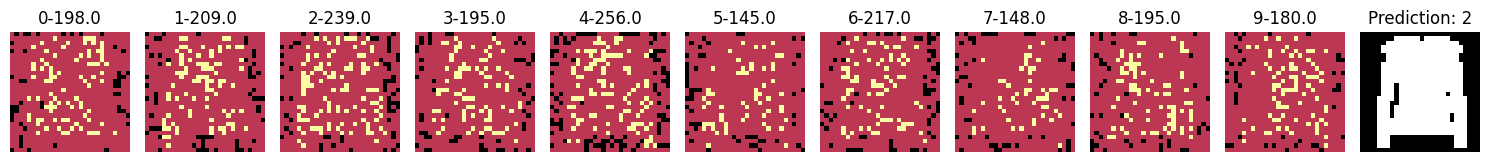

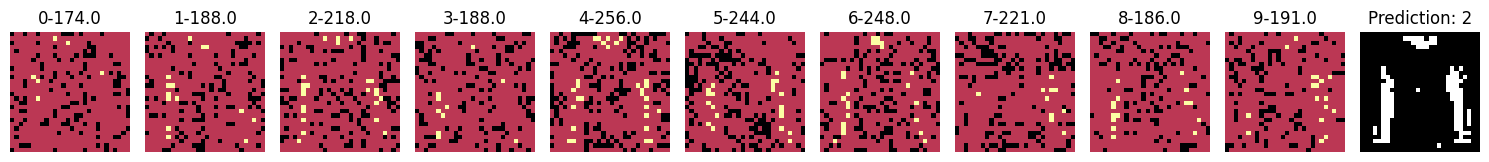

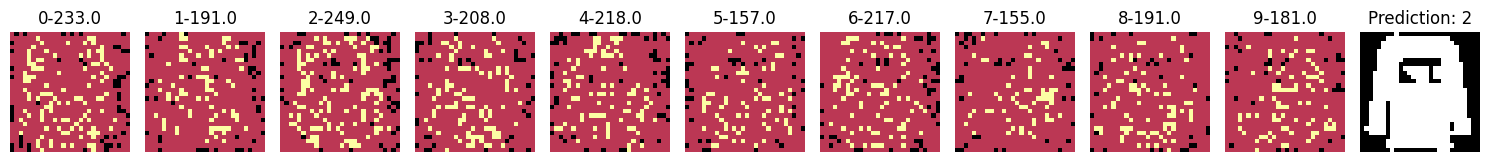

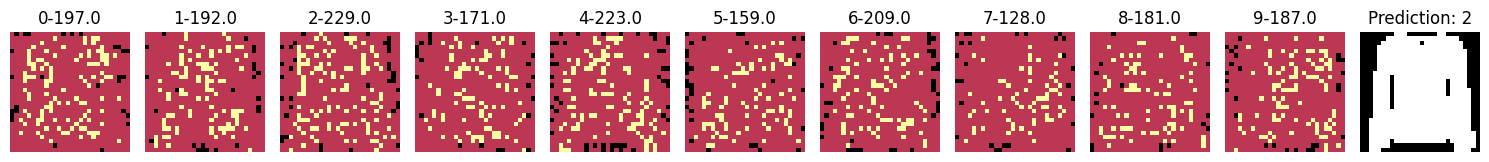

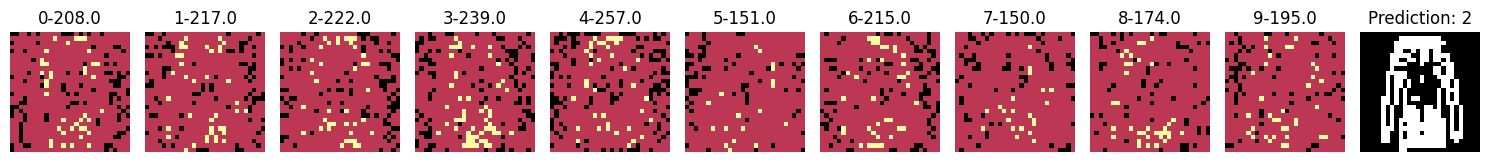

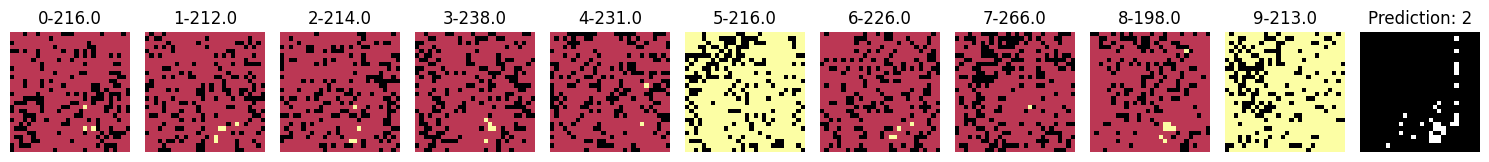

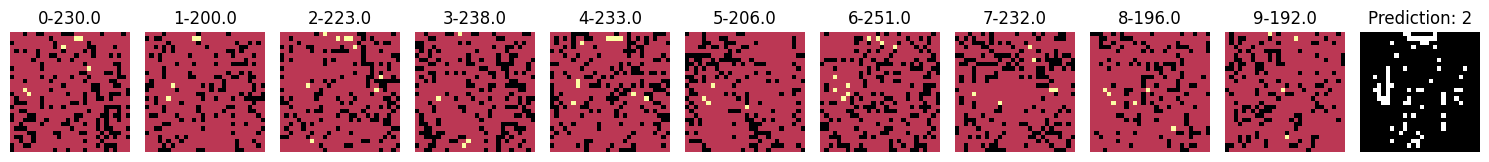

In [51]:
mode = "sf"  # Options: "sp"/"sf"
thresholds = [0.0]
p_type = "FP"
class_num = 2

# Switching Frequency/Probability based local explanations
model.flatten = lambda x: torch.flatten(x).reshape(1, shape[0] * shape[1])

def visualize_class_data(g, data, outputs, ax, mode, thresholds):
    """
    Visualizes the class data and overlays the explanations.
    """
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in, pixels = visualize_fan_in(g.g, output_node, threshold, True, False)
            im.append(img)

        img = np.average(im, axis=0)
        overlap = np.array(img.flatten() == (data * 2 - 1).cpu().detach().numpy()).astype(int)
        
        # Overlay the explanation and display
        ax[i].imshow((img.flatten() * overlap).reshape((shape[0], shape[1], 1)), cmap="inferno")
        ax[i].set_title(f"{i}-{np.sum(np.abs(img))}")
        ax[i].axis("off")  # Turn off the axes for cleaner display

    # Show the input data
    ax[len(outputs)].imshow(data.reshape((shape[0], shape[1], 1)), cmap="gray")
    ax[len(outputs)].set_title(f"Prediction: {np.argmax(np.array(g.forward(data.float().view(1, -1)).cpu().detach()))}")
    ax[len(outputs)].axis("off")  # Turn off the axes for cleaner display

# Main Loop
for k, (data, label) in enumerate(class_specific_datasets[f'{p_type}_class'][class_num].dataset): 
    g = lg.LogicGraph(model)
    
    # Compute either sf or sp based on the mode
    if mode == "sf": 
        g.compute_sf(data.unsqueeze(0).to(float))
    elif mode == "sp":
        g.compute_sp(data.unsqueeze(0).to(float))
    
    # Set up the figure
    fig, ax = plt.subplots(1, len(outputs) + 1, figsize=(15, 10))
    
    # Visualize the class data
    visualize_class_data(g, data, outputs, ax, mode, thresholds)
    
    # Display the visualization
    plt.tight_layout()  # Ensure everything fits nicely
    plt.show()
    
    # Stop after showing 5 images
    if k > 5: 
        break

Compare Evidence for TP/FN/FP cases

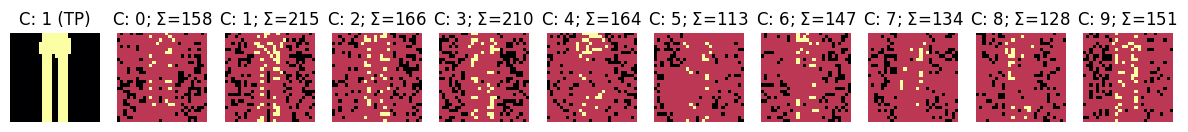

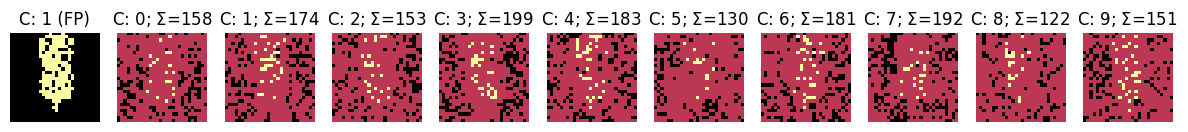

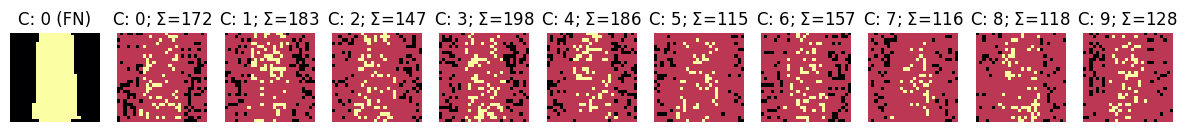

In [52]:
def visualize_class_data(dataset, class_name, label, model, outputs, shape):
    for k, (data, _) in enumerate(dataset):
        g = lg.LogicGraph(model)
        g.compute_sf(data.unsqueeze(0).to(float))
        
        fig, ax = plt.subplots(1, len(outputs) + 1, figsize=(15, 10))
        thresholds = [0.0]
        
        for i, output_node in enumerate(outputs):
            im = []
            for threshold in thresholds:
                img, fan_in, pixels = visualize_fan_in(g.g, output_node, threshold, True, False)
                im.append(img)
            
            img = np.average(im, axis=0)
            overlap = np.array(img.flatten() == (data * 2 - 1).cpu().detach().numpy()).astype(int)
            
            ax[i + 1].imshow((img.flatten() * overlap).reshape((shape[0], shape[1], 1)), "inferno", vmin=-1, vmax=1)
            ax[i + 1].title.set_text(f"C: {i}; $\Sigma$={int(np.sum(np.abs(img).flatten() * overlap))}")
            ax[i + 1].set_axis_off()
        
        ax[0].imshow(data.reshape((shape[0], shape[1], 1)), "inferno")
        ax[0].title.set_text(f"C: {np.argmax(np.array(g.forward(data.float().view(1, -1)).cpu().detach()))} ({class_name})")
        ax[0].set_axis_off()
        
        plt.show()
        
        break

# Visualize True Positive, False Positive, and False Negative class data
index = 1
visualize_class_data(class_specific_datasets['TP_class'][index].dataset, 'TP', label, model, outputs, shape)
visualize_class_data(class_specific_datasets['FP_class'][index].dataset, 'FP', label, model, outputs, shape)
visualize_class_data(class_specific_datasets['FN_class'][index].dataset, 'FN', label, model, outputs, shape)

### **MiniNets**

Model Declaration

In [83]:
# write the name of the model you want to work with
model_name = 'model_001'

# declare file paths
trained_models_dir = f'trained_models/{dataset_name}_trained_models/'
with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    model_cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")
model_cfg = model_cfg['models'][model_name]

# instantiate a DiffLogic model
model = DiffLogic(layers_config=model_cfg['layers_config'], 
    output_size=model_cfg['output_size'], 
    tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')    

# load the DiffLogic model "weights" (the logic gates/connections) 
model_path = os.path.join(trained_models_dir, model_name + ".pth")
model.load(model_path)

LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)


MiniNet Class

In [84]:
def bin_op(a, b, i):
    """
    Compute the logic gate outputs for given inputs and gate indices.
    
    Args:
        a: Tensor of shape (batch_size, out_dim)
        b: Tensor of shape (batch_size, out_dim)
        i: Tensor of shape (out_dim,), representing gate indices.

    Returns:
        Tensor of shape (batch_size, out_dim), the computed outputs.
    """
    # Define operations for all possible gates
    gate_ops = {
        0: lambda a, b: torch.zeros_like(a),  # zero
        1: lambda a, b: a * b,  # and
        2: lambda a, b: a - a * b,  # not_implies
        3: lambda a, b: a,  # a
        4: lambda a, b: b - a * b,  # not_implied_by
        5: lambda a, b: b,  # b
        6: lambda a, b: a + b - 2 * a * b,  # xor
        7: lambda a, b: a + b - a * b,  # or
        8: lambda a, b: 1 - (a + b - a * b),  # not_or
        9: lambda a, b: 1 - (a + b - 2 * a * b),  # not_xor
        10: lambda a, b: 1 - b,  # not_b
        11: lambda a, b: 1 - b + a * b,  # implied_by
        12: lambda a, b: 1 - a,  # not_a
        13: lambda a, b: 1 - a + a * b,  # implies
        14: lambda a, b: 1 - a * b,  # not_and
        15: lambda a, b: torch.ones_like(a),  # one
    }

    outputs = torch.zeros_like(a, dtype=torch.float32)

    for gate_idx in torch.unique(i):
        mask = (i == gate_idx).unsqueeze(0)  # Shape: (1, out_dim)
        gate_output = gate_ops[gate_idx.item()](a, b)
        outputs += gate_output * mask.float()
    return outputs


class CustomLogicLayer(torch.nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        connections: torch.Tensor,  # Connections between input and output nodes
        logic_gates: list,          # Logic gates for each output neuron
        device: str = "cuda",
    ):
        super().__init__()
        self.indices = connections.to(device)
        self.logic_gates = torch.tensor(logic_gates, dtype=torch.long, device=device)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device

    def forward(self, x):
        return self.forward_python(x)

    def forward_python(self, x):
        assert x.shape[-1] == self.in_dim, (x.shape[-1], self.in_dim)
        
        a = x[..., self.indices[:, 0]]  # Shape: (batch_size, out_dim)
        b = x[..., self.indices[:, 1]]  # Shape: (batch_size, out_dim)

        gate_indices = self.logic_gates  # Shape: (out_dim,)

        # Compute the outputs using bin_op and the known gate indices
        outputs = bin_op(a, b, gate_indices)
        return outputs

    def extra_repr(self):
        return "{}, {}, {}".format(self.in_dim, self.out_dim, "train" if self.training else "eval")
    
    
class CustomDiffLogic(torch.nn.Module):
    def __init__(self, layer_specs, output_size=10, device="cuda", tau=30):
        """
        Constructs a network using layers of logic gates and custom connections.
        
        Args:
            layer_specs (list): List of layer specifications, each containing
                                input size, output size, connections, and logic gates.
            output_size (int): Number of output groups/classes.
            device (str): Device for computation (e.g., 'cuda' or 'cpu').
            tau (int): Temperature parameter for the GroupSum layer.
        """
        super(CustomDiffLogic, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.device = device

        layers = []

        # Create each layer with specific connections and logic gates
        for layer_spec in layer_specs:
            layer = CustomLogicLayer(
                in_dim=layer_spec["input_size"],
                out_dim=layer_spec["output_size"],
                connections=layer_spec["connections"],
                logic_gates=layer_spec["logic_gates"],
                device=self.device,
            )
            layers.append(layer)

        self.logic_layers = torch.nn.Sequential(*layers)
        #self.group = GroupSum(k=output_size, tau=tau)

    def forward(self, x):
        # Flatten input for processing
        if torch.cuda.is_available():
            x = x.to(self.device)

        x = self.flatten(x)
        logits = self.logic_layers(x)

        output = logits.sum(dim=1)
        
        # Grouping the final logits
        return output

Ensures there are no leftover hooks before we begin

In [85]:
# function to remove all forward and backward hooks in a model
def remove_all_hooks(model):
    # pass through modules (layers) in the model
    for layer in model.modules():
        # check and remove forward hooks
        if hasattr(layer, "_forward_hooks"):
            layer._forward_hooks.clear()
        
        # check and remove backward hooks
        if hasattr(layer, "_backward_hooks"):
            layer._backward_hooks.clear()
        
        # also checks for pre-forward hooks (rare) and removes them
        if hasattr(layer, "_forward_pre_hooks"):
            layer._forward_pre_hooks.clear()

# call the function to remove all hooks from the model
remove_all_hooks(model)

Creates data loaders for each individual class

e.g. A dataloader where all samples correspond to class "1"

In [86]:
# Create class-specific data loaders for training and testing sets if they haven't been created
if 'train_class_loaders' not in locals():
    train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size)
if 'test_class_loaders' not in locals():
    test_class_loaders = subset.create_class_dataloaders(test_dataset, batch_size)

Tracks the activation of EACH node. 

For example, if we pass 10 images of the number "1", the middle vertical pixels (aka nodes in the model) of the image would be "ON" probably all 10 times. 

We interpret those pixels as being activated 10 times out of 10 times. Pixels in the corner of the images are less likely to be activated, so their count would most likely be closer to 0 in this example.

"Activated" just means the output of a node is 1.

In [87]:
# track activations for a specific digit
def hook_fn(module, input, output, layer_idx, digit, debug=False):
    if len(activation_counts_per_digit[digit]) <= layer_idx:
        activation_counts_per_digit[digit].append(np.zeros(output.size(1), dtype=np.int64))
        
    activation_counts_per_digit[digit][layer_idx] = activation_counts_per_digit[digit][layer_idx].astype(np.int64)
    
    # prints before adding to check the behavior
    if debug:
        print(f"Before accumulation for digit {digit}, Layer {layer_idx}, Counts: {activation_counts_per_digit[digit][layer_idx]}")
        print(f"Activation counts for digit {digit} (output > 0): {(output > 0).sum(dim=0).cpu().numpy()}")
      
    activation_counts_per_digit[digit][layer_idx] += (output > 0).sum(dim=0).cpu().numpy().astype(np.int64)
    
    # prints after accumulation to see the updated counts
    if debug:
        print(f"After accumulation for digit {digit}, Layer {layer_idx}, Counts: {activation_counts_per_digit[digit][layer_idx]}")


# run forward pass and collect activations for each digit's dataset
def run_and_collect_activations(model, digit_loaders):
    for digit, loader in digit_loaders.items():
        hooks = []

        for idx, layer in enumerate(model.logic_layers):
            if isinstance(layer, LogicLayer): 
                hook = layer.register_forward_hook(
                    (lambda layer_idx, digit: 
                        lambda module, input, output: 
                            hook_fn(module, input, output, layer_idx, digit))(idx, digit)
                )
                hooks.append(hook)

        for batch_data, _ in loader:
            batch_data = batch_data.float().to('cuda')  # Ensure correct type and device
            model(batch_data)

        for hook in hooks:
            hook.remove()

# initializes an empty dictionary to be populated with how often pixels are activated
activation_counts_per_digit = {digit: [] for digit in range(10)} 
# passes trained DiffLogic model and dictionary of individual digit loaders
run_and_collect_activations(model, train_class_loaders)

This is where we actually decide which nodes to get rid off.

Based on how often each node was activated (previous code block), we decide whether to remove or keep that pixel.

This number can be tweaked to be more lenient or more strict (the higher the number, the more a pixel needs to be activated to be considered important)

In [88]:
# switching frequency (sf) refers to the PROPORTION of activated nodes
# e.g. a node activates 75 times out of 100 samples -> sf = 75/100 = 0.75
# higher switching frequency means more nodes will be removed
SWITCHING_FREQUENCY = 0.75

In [89]:
def threshold_activation_counts(activation_counts, sf=0.50):
    # dictionary to store the thresholded values
    thresholded_counts = {}
    
    # iterates through each digit and layer in the activation_counts
    for digit, layers in activation_counts.items():
        thresholded_counts[digit] = []
        
        most_activations = max(max(layer_array) for layer_array in layers)
            
        # calculates the threshold of how many times a node has to be activated
        threshold = sf * most_activations
        
        for layer_array in layers:
            # applies threshold, set values above 'threshold' to 1, otherwise 0
            thresholded_layer = (layer_array > threshold).astype(int)
            thresholded_counts[digit].append(thresholded_layer)
    
    return thresholded_counts

thresholded_activation_counts_per_digit = threshold_activation_counts(activation_counts_per_digit, sf=SWITCHING_FREQUENCY)

Now we use the thresholded activation counts to find the unused nodes (the ones that didn't activate enough times)

In [90]:
def find_unused_nodes(thresholded_counts):
    unused_nodes_per_digit = {}

    # iterate through each digit
    for digit, layers in thresholded_counts.items():
        unused_nodes_per_digit[digit] = []
        
        # iterate through each layer for the current digit
        for layer_idx, layer_activations in enumerate(layers):
            # find the indices of nodes that are always zero in this layer
            unused_nodes = {node_idx for node_idx, activation_value in enumerate(layer_activations) if activation_value == 0}
            # append the unused nodes set for the current layer
            unused_nodes_per_digit[digit].append(unused_nodes)
            
    return unused_nodes_per_digit

unused_gates_per_digit = find_unused_nodes(thresholded_activation_counts_per_digit)

We need to get the connections for our base model

In [91]:
# gets the connections for the overall model
def get_all_connections(model):
    
    # map gate names to indices
    ALL_OPERATIONS = [
        "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
        "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
    ]

    gates_per_layer = []
    
    for layer_idx, layer in enumerate(model.logic_layers):
        layer_connections = []
        
        # for each neuron in the layer
        for neuron_idx in range(layer.weights.size(0)):
            # get the learned gate by taking the argmax of the weights for the neuron
            gate_op_idx = layer.weights[neuron_idx].argmax().item()
            learned_gate = ALL_OPERATIONS[gate_op_idx]

            # get the input connections (indices) for the gate
            input_neuron_a = layer.indices[0][neuron_idx].item()
            input_neuron_b = layer.indices[1][neuron_idx].item()

            # store the gate and connections
            layer_connections.append({
                'neuron_idx': neuron_idx,
                'gate': learned_gate,
                'inputs': (input_neuron_a, input_neuron_b),
            })
        
        gates_per_layer.append(layer_connections)
    
    return gates_per_layer

# retrieve all connections for the model
connections = get_all_connections(model)
connections[0][:5] # example displaying the first 5

[{'neuron_idx': 0, 'gate': 'b', 'inputs': (660, 648)},
 {'neuron_idx': 1, 'gate': 'not_or', 'inputs': (560, 196)},
 {'neuron_idx': 2, 'gate': 'not_and', 'inputs': (658, 540)},
 {'neuron_idx': 3, 'gate': 'not_or', 'inputs': (511, 316)},
 {'neuron_idx': 4, 'gate': 'not_xor', 'inputs': (28, 69)}]

Code below ensures we don't have "ghost" references

If a node is referenced and not in our list of activated nodes, the referenced node is added to the list

In [92]:
# makes sure no gate references an unused digit
def propagate_activity(connections, unused_nodes_per_digit, digit):
    """
    Propagates neuron activity backward through the layers. If a neuron in the second layer is active, 
    it makes the connected neurons in the first layer active.
    
    Args:
    connections (list): List of connections for each layer for the overall model.
    unused_nodes_per_digit (dict): Dictionary of unused nodes per digit and layer.
    digit (int): The digit to process.

    Returns:
    updated_unused_nodes_per_digit (dict): The updated dictionary with necessary nodes marked as active.
    """
    # Copy the unused_nodes_per_digit to modify it
    updated_unused_nodes_per_digit = copy.deepcopy(unused_nodes_per_digit)

    # Iterate backward through layers (starting from the second-to-last)
    for layer_idx in range(len(connections) - 1, 0, -1):
        # Get the current layer's connections and unused nodes
        layer_connections = connections[layer_idx]
        unused_nodes_in_layer = updated_unused_nodes_per_digit[digit][layer_idx]

        # Check which neurons are active in the current layer
        active_neurons = {conn['neuron_idx'] for conn in layer_connections if conn['neuron_idx'] not in unused_nodes_in_layer}

        # Activate the neurons in the previous layer that are connected to active neurons in the current layer
        for conn in layer_connections:
            if conn['neuron_idx'] in active_neurons:
                input_a, input_b = conn['inputs']
                # Remove these neurons from the "unused" set, making them active
                updated_unused_nodes_per_digit[digit][layer_idx - 1].discard(input_a)
                updated_unused_nodes_per_digit[digit][layer_idx - 1].discard(input_b)

    return updated_unused_nodes_per_digit

def filter_connections_after_propagation(connections, unused_nodes_per_digit, digit):
    """
    Filters out unused gates and updates connections after propagating neuron activity.
    
    Args:
    - connections (list): List of connections for each layer.
    - unused_nodes_per_digit (dict): Updated dictionary of unused nodes per digit and layer.
    - digit (int): The digit to process.
    
    Returns:
    - filtered_connections (list): The adjusted connections after removing unused gates.
    """
    filtered_connections = []

    for layer_idx, layer_connections in enumerate(connections):
        layer_unused_nodes = unused_nodes_per_digit[digit][layer_idx]
        
        # Filter out connections where the neuron index is in the unused nodes
        filtered_layer_connections = [
            conn for conn in layer_connections if conn['neuron_idx'] not in layer_unused_nodes
        ]
        
        filtered_connections.append(filtered_layer_connections)

    return filtered_connections

def process_network_with_propagation(connections, unused_nodes_per_digit, digit):
    # Step 1: Propagate activity backward
    updated_unused_nodes_per_digit = propagate_activity(connections, unused_nodes_per_digit, digit)
    
    # Step 2: Filter connections based on updated activity
    filtered_connections = filter_connections_after_propagation(connections, updated_unused_nodes_per_digit, digit)
    
    return filtered_connections

Mapping of logic gates to their actual mathematical representation

In [93]:
# map gate names to indices
ALL_OPERATIONS = [
    "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
    "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
]

# map gate names to indices
gate_name_to_index = {name: idx for idx, name in enumerate(ALL_OPERATIONS)}

We need to know what Logic Gate was learned at each one of the nodes

In [94]:
# extract logic gates per layer
def extract_logic_gates_per_layer(adjusted_connections, gate_name_to_index):
    logic_gates_per_layer = []
    for layer_connections in adjusted_connections:
        # Convert each gate name to its corresponding index
        logic_gates = [gate_name_to_index[conn['gate']] for conn in layer_connections]
        logic_gates_per_layer.append(logic_gates)
    return logic_gates_per_layer

# loop for all digits
logic_gates_per_layer_per_digit = {}
for digit in range(10):
    # example usage
    adjusted_connections_per_digit = process_network_with_propagation(connections, unused_gates_per_digit, digit)
    logic_gates_per_layer_per_digit[digit] = extract_logic_gates_per_layer(adjusted_connections_per_digit, gate_name_to_index)

Layer Specs is what we will pass when creating the Miniature model.

It is simply the format/order the model expects this data to be passed

In [95]:
def create_layer_specs(adjusted_connections, logic_gates_per_layer, input_size):
    layer_specs = []
    previous_absolute_indices = None
    previous_absolute_to_relative = None

    for layer_idx, layer_connections in enumerate(adjusted_connections):
        if layer_idx == 0:
            # First Layer
            current_input_size = input_size
            output_size = len(layer_connections)

            # Build mapping from output neuron absolute indices to relative indices
            absolute_indices = [conn['neuron_idx'] for conn in layer_connections]
            absolute_to_relative = {abs_idx: rel_idx for rel_idx, abs_idx in enumerate(absolute_indices)}

            # Connections: no need to remap inputs
            connections = torch.tensor([conn['inputs'] for conn in layer_connections], dtype=torch.long).to('cuda')

            logic_gates = logic_gates_per_layer[layer_idx]
            layer_specs.append({
                'input_size': current_input_size,
                'output_size': output_size,
                'connections': connections,
                'logic_gates': logic_gates,
            })

            previous_absolute_indices = absolute_indices
            previous_absolute_to_relative = absolute_to_relative
        else:
            # Subsequent Layers
            current_input_size = len(previous_absolute_indices)
            output_size = len(layer_connections)

            # Remap inputs using previous layer's absolute to relative mapping
            connections = []
            for conn in layer_connections:
                input_a_abs = conn['inputs'][0]
                input_b_abs = conn['inputs'][1]

                # Map absolute indices to relative indices
                input_a_rel = previous_absolute_to_relative[input_a_abs]
                input_b_rel = previous_absolute_to_relative[input_b_abs]
                connections.append((input_a_rel, input_b_rel))

            connections = torch.tensor(connections, dtype=torch.long).to('cuda')
            logic_gates = logic_gates_per_layer[layer_idx]
            layer_specs.append({
                'input_size': current_input_size,
                'output_size': output_size,
                'connections': connections,
                'logic_gates': logic_gates,
            })

            # Update mappings for the next layer
            absolute_indices = [conn['neuron_idx'] for conn in layer_connections]
            absolute_to_relative = {abs_idx: rel_idx for rel_idx, abs_idx in enumerate(absolute_indices)}
            previous_absolute_indices = absolute_indices
            previous_absolute_to_relative = absolute_to_relative
        
    return layer_specs

We will have one MiniNet per class (digit for the MNIST example). 

In [96]:
models_per_digit = {}

# Loop over all digits from 0 to 9
for digit in range(10):
    print(f"Processing digit {digit}")

    # All the necessary (used) connections for the current digit
    full_connections_for_digit = process_network_with_propagation(connections, unused_gates_per_digit, digit=digit)

    # All the logic gates (nodes) needed in the current digit
    logic_gates_per_layer = extract_logic_gates_per_layer(full_connections_for_digit, gate_name_to_index)

    # Combined list of gates and connections
    layer_specs = create_layer_specs(full_connections_for_digit, logic_gates_per_layer, input_size=784)

    # Create the custom model
    custom_model = CustomDiffLogic(layer_specs)

    # Move model to device
    if torch.cuda.is_available():
        custom_model = custom_model.to('cuda')

    # Store the model in the dictionary
    models_per_digit[digit] = custom_model

    # Print the reduced model architecture
    print(custom_model)

Processing digit 0
CustomDiffLogic(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logic_layers): Sequential(
    (0): CustomLogicLayer(784, 2390, train)
    (1): CustomLogicLayer(2390, 1017, train)
  )
)
Processing digit 1
CustomDiffLogic(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logic_layers): Sequential(
    (0): CustomLogicLayer(784, 3649, train)
    (1): CustomLogicLayer(3649, 1826, train)
  )
)
Processing digit 2
CustomDiffLogic(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logic_layers): Sequential(
    (0): CustomLogicLayer(784, 2200, train)
    (1): CustomLogicLayer(2200, 908, train)
  )
)
Processing digit 3
CustomDiffLogic(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logic_layers): Sequential(
    (0): CustomLogicLayer(784, 3137, train)
    (1): CustomLogicLayer(3137, 1478, train)
  )
)
Processing digit 4
CustomDiffLogic(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logic_layers): Sequential(
    (0): CustomLogicLayer(784, 3014, train)
    (1): CustomLo

Because the MiniNet is now a binary classifier, we need to measure accuracy differently

In [98]:
def accuracy_one_vs_all(model, dataloader, digit, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # The model returns a raw logit in [-∞, +∞]
            logits = model(inputs)  # shape [batch_size]
            
            # Convert logit -> probability in [0,1]
            prob = torch.sigmoid(logits)
            predictions = (prob > 0.5).float()

            # Convert ground-truth labels to 0/1
            binary_labels = (labels == digit).float()

            correct += (predictions == binary_labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"One-vs.-all Accuracy for digit {digit}: {accuracy * 100:.2f}%")
    return accuracy

# Example usage
# accuracy_one_vs_all(mini_difflogic, test_class_loaders[0], 0)

In [99]:
accuracies_on_test_loader = {}
accuracies_on_digit_loader = {}

# Evaluate the model with a 0.5 threshold
for digit in range(10):
    test_loader_accuracy = accuracy_one_vs_all(models_per_digit[digit], test_loader, digit)
    print(f"Accuracy on TestLoader for reduced model of digit {digit}: {test_loader_accuracy}")
    accuracies_on_test_loader[digit] = test_loader_accuracy
        
    digit_loader_accuracy = accuracy_one_vs_all(models_per_digit[digit], test_class_loaders[digit], digit)
    print(f"Accuracy on DigitLoader {digit} for reduced model of digit {digit}: {digit_loader_accuracy}")
    accuracies_on_digit_loader[digit] = digit_loader_accuracy

One-vs.-all Accuracy for digit 0: 9.93%
Accuracy on TestLoader for reduced model of digit 0: 0.09930098684210527
One-vs.-all Accuracy for digit 0: 100.00%
Accuracy on DigitLoader 0 for reduced model of digit 0: 1.0
One-vs.-all Accuracy for digit 1: 10.08%
Accuracy on TestLoader for reduced model of digit 1: 0.10084292763157894
One-vs.-all Accuracy for digit 1: 100.00%
Accuracy on DigitLoader 1 for reduced model of digit 1: 1.0
One-vs.-all Accuracy for digit 2: 9.87%
Accuracy on TestLoader for reduced model of digit 2: 0.09868421052631579
One-vs.-all Accuracy for digit 2: 100.00%
Accuracy on DigitLoader 2 for reduced model of digit 2: 1.0
One-vs.-all Accuracy for digit 3: 9.97%
Accuracy on TestLoader for reduced model of digit 3: 0.09971217105263158
One-vs.-all Accuracy for digit 3: 100.00%
Accuracy on DigitLoader 3 for reduced model of digit 3: 1.0
One-vs.-all Accuracy for digit 4: 9.94%
Accuracy on TestLoader for reduced model of digit 4: 0.09940378289473684
One-vs.-all Accuracy for d

But that accuracy can be greatly increased if we find the **optimal threshold**

In [100]:
def collect_outputs_and_labels(model, data_loader, digit, device='cuda'):
        outputs_list = []
        labels_list = []

        model.eval()

        with torch.no_grad():
            for batch_inputs, batch_labels in tqdm(data_loader, desc="Collecting Outputs"):
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)
                
                # Adjust labels to binary
                binary_labels = (batch_labels == digit).float()

                # Forward pass
                outputs = model(batch_inputs)

                # Store outputs and labels
                outputs_list.append(outputs.cpu())
                labels_list.append(binary_labels.cpu())

        # Concatenate all outputs and labels
        outputs = torch.cat(outputs_list).squeeze()
        labels = torch.cat(labels_list)
        
        return outputs, labels


def find_optimal_threshold(outputs, labels):
    from sklearn.metrics import precision_recall_curve
    import numpy as np

    # Calculate precision and recall for various thresholds
    precision, recall, thresholds = precision_recall_curve(labels, outputs)

    # Avoid division by zero
    epsilon = 1e-6

    # Calculate F1 scores
    f1_scores = 2 * precision * recall / (precision + recall + epsilon)

    # Find the threshold that maximizes the F1 score
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Maximum F1 Score: {f1_scores[max_f1_idx]}")

    return optimal_threshold, precision[max_f1_idx], recall[max_f1_idx], f1_scores[max_f1_idx]
    
    
def thresholded_accuracy(outputs, labels, threshold):
    predictions = (outputs > threshold).float()
    correct = (predictions == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [101]:
reduced_model_accuracies = {}

for digit in range(10):
    outputs, labels = collect_outputs_and_labels(models_per_digit[digit], test_loader, digit)
    optimal_threshold, precision, recall, f1_score = find_optimal_threshold(outputs, labels)
    accuracy = thresholded_accuracy(outputs, labels, optimal_threshold)
    reduced_model_accuracies[digit] = accuracy
    print(f"Accuracy for reduced model of digit {digit}: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

Optimal Threshold: 910.0
Maximum F1 Score: 0.5326577280855834
Accuracy for reduced model of digit 0: 0.9055
Precision: 0.5213, Recall: 0.5445, F1 Score: 0.5327


Optimal Threshold: 1622.0
Maximum F1 Score: 0.7667936041435436
Accuracy for reduced model of digit 1: 0.9557
Precision: 0.8259, Recall: 0.7156, F1 Score: 0.7668


Optimal Threshold: 766.0
Maximum F1 Score: 0.4015316528309338
Accuracy for reduced model of digit 2: 0.8085
Precision: 0.2895, Recall: 0.6552, F1 Score: 0.4015


Optimal Threshold: 1347.0
Maximum F1 Score: 0.5996247566464648
Accuracy for reduced model of digit 3: 0.9343
Precision: 0.7607, Recall: 0.4948, F1 Score: 0.5996


Optimal Threshold: 1223.0
Maximum F1 Score: 0.5522732971326225
Accuracy for reduced model of digit 4: 0.9016
Precision: 0.5051, Recall: 0.6091, F1 Score: 0.5523


Optimal Threshold: 1422.0
Maximum F1 Score: 0.4636497287909598
Accuracy for reduced model of digit 5: 0.8924
Precision: 0.4611, Recall: 0.4663, F1 Score: 0.4636


Optimal Threshold: 739.0
Maximum F1 Score: 0.30472057389226304
Accuracy for reduced model of digit 6: 0.8034
Precision: 0.2351, Recall: 0.4329, F1 Score: 0.3047


Optimal Threshold: 1512.0
Maximum F1 Score: 0.7813847829088326
Accuracy for reduced model of digit 7: 0.9583
Precision: 0.8270, Recall: 0.7405, F1 Score: 0.7814


Optimal Threshold: 796.0
Maximum F1 Score: 0.6639048378309662
Accuracy for reduced model of digit 8: 0.9418
Precision: 0.7879, Recall: 0.5736, F1 Score: 0.6639


Optimal Threshold: 1264.0
Maximum F1 Score: 0.7907450012921395
Accuracy for reduced model of digit 9: 0.9581
Precision: 0.7879, Recall: 0.7936, F1 Score: 0.7907


#### **A Single Pipeline**

In [103]:
def run_full_mininet_pipeline(
    base_model, 
    train_dataset, 
    test_dataset, 
    input_size,
    switching_frequency=0.75, 
    batch_size=512,
    device='cuda'
):
    """
    Orchestrates the entire pipeline to create MiniNets (one per digit/class).
    
    Args:
        base_model (DiffLogic): The trained DiffLogic model.
        train_dataset (Dataset): The full training dataset.
        test_dataset (Dataset): The full test dataset.
        switching_frequency (float): The proportion of activations at which 
                                     to threshold nodes as "unused".
        batch_size (int): Batch size for creating class-specific dataloaders.
        device (str): The device to be used ("cuda" or "cpu").

    Returns:
        models_per_digit (dict): A dictionary mapping each digit (0-9) to its reduced CustomDiffLogic model.
        accuracies_on_test_loader (dict): Accuracy (with threshold=0.5) of each digit's reduced model on the full test set.
        accuracies_on_digit_loader (dict): Accuracy (with threshold=0.5) of each digit's reduced model on 
                                           its own digit-specific test set.
        reduced_model_accuracies (dict): Accuracy (with the optimal threshold found via precision-recall) 
                                         of each digit's reduced model on the full test set.
    """

    # --------------------------------------------------
    # 1) Remove all existing hooks from the base model
    # --------------------------------------------------
    # Reason: we need a clean slate, free of leftover hooks 
    # that may interfere with new forward_pass hooks used 
    # for activation tracking.
    remove_all_hooks(base_model)
    
    # --------------------------------------------------
    # 2) Create class-specific dataloaders
    # --------------------------------------------------
    # Reason: we need separate data loaders for each digit 
    # so we can track which gates/nodes are used by each digit.
    train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size)
    test_class_loaders = subset.create_class_dataloaders(test_dataset, batch_size)
    
    # --------------------------------------------------
    # 3) Track activation counts for each digit
    # --------------------------------------------------
    # Reason: we do a forward pass for each digit's samples 
    # to figure out how many times each node is "ON" (activated).
    activation_counts_per_digit = {digit: [] for digit in range(10)}
    run_and_collect_activations(base_model, train_class_loaders)
    
    # --------------------------------------------------
    # 4) Apply thresholding to decide which nodes are "unused"
    #    based on the switching_frequency
    # --------------------------------------------------
    # Reason: threshold_activation_counts returns a dictionary 
    # of 0/1 values (1 = "keep", 0 = "remove").
    thresholded_activation_counts_per_digit = threshold_activation_counts(
        activation_counts_per_digit, 
        sf=switching_frequency
    )
    
    # --------------------------------------------------
    # 5) Find the "unused" nodes per digit
    # --------------------------------------------------
    # Reason: we now know which nodes have effectively never 
    # or rarely turned "ON" for a particular digit.
    unused_gates_per_digit = find_unused_nodes(thresholded_activation_counts_per_digit)
    
    # --------------------------------------------------
    # 6) Retrieve all connections (gates + input indices) 
    #    from the original DiffLogic model
    # --------------------------------------------------
    # Reason: we’ll need the base model’s connections to decide 
    # which ones to keep or discard based on usage.
    connections = get_all_connections(base_model)
    
    # --------------------------------------------------
    # 7) For each digit, filter out unused gates 
    #    and create a "mini" model
    # --------------------------------------------------
    # Reason: each digit’s specialized sub-network is created by 
    # removing all the gates it does not use.
    models_per_digit = {}
    for digit in range(10):
        # 7a) Propagate activity and filter out truly unused connections
        full_connections_for_digit = process_network_with_propagation(connections, unused_gates_per_digit, digit=digit)
        
        # 7b) Extract the gate indices
        logic_gates_per_layer = extract_logic_gates_per_layer(full_connections_for_digit, gate_name_to_index)
        
        # 7c) Create the layer_specs needed to build a CustomDiffLogic
        layer_specs = create_layer_specs(
            adjusted_connections=full_connections_for_digit, 
            logic_gates_per_layer=logic_gates_per_layer, 
            input_size=input_size  
        )
        
        # 7d) Construct the "mini" model for this digit
        custom_model = CustomDiffLogic(layer_specs, device=device)
        custom_model.to(device)
        
        # Store in the dictionary
        models_per_digit[digit] = custom_model
    
    # --------------------------------------------------
    # 8) Evaluate these "mini" models
    # --------------------------------------------------
    # Reason: we want to measure how well each digit’s reduced model 
    # separates "digit vs. not-digit" with a 0.5 threshold 
    # and also with an optimal threshold.
    accuracies_on_test_loader = {}
    accuracies_on_digit_loader = {}
    
    # 8a) Evaluate the accuracy on the whole test dataset and on the specific one for that class
    for digit in range(10):
        test_loader_accuracy = accuracy_one_vs_all(models_per_digit[digit], test_dataset, digit, device=device)
        accuracies_on_test_loader[digit] = test_loader_accuracy

        digit_loader_accuracy = accuracy_one_vs_all(models_per_digit[digit], test_class_loaders[digit], digit, device=device)
        accuracies_on_digit_loader[digit] = digit_loader_accuracy
    
    # 8b) Evaluate with an optimal threshold (based on precision-recall)
    reduced_model_accuracies = {}
    for digit in range(10):
        outputs, labels = collect_outputs_and_labels(models_per_digit[digit], test_dataset, digit, device=device)
        
        optimal_threshold, precision, recall, f1_score = find_optimal_threshold(outputs, labels)
        accuracy_opt_threshold = thresholded_accuracy(outputs, labels, optimal_threshold)
        
        reduced_model_accuracies[digit] = accuracy_opt_threshold
        print(f"[Digit {digit}] - Optimal threshold = {optimal_threshold}, Accuracy = {accuracy_opt_threshold:.4f}, "
              f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1_score:.4f}")
    
    # Return all the final mini-models and their accuracies
    return models_per_digit, accuracies_on_test_loader, accuracies_on_digit_loader, reduced_model_accuracies

In [104]:
## HAVE NOT LOOKED INTO WHY THIS IS FAILING, WILL CHECK TOMORROW

models_per_digit, acc_test_loader, acc_digit_loader, reduced_accs = run_full_mininet_pipeline(
    base_model=model, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    input_size=784,
    switching_frequency=0.75, 
    batch_size=512,
    device='cuda'
)

ValueError: max() arg is an empty sequence

-----

#### **Creating MiniNets with Stephen Code [Ignore For Now]**

In [14]:
# Create class-specific data loaders for training and testing sets if they haven't been created
if 'train_class_loaders' not in locals():
    train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size)
if 'test_class_loaders' not in locals():
    test_class_loaders = subset.create_class_dataloaders(test_dataset, batch_size)

In [15]:
# Compute SF for each graph (e.g. digits 0-9 for MNIST) 
graphs = {}

for g in range(10): 
    print(f"Class {g}")
    graphs[g] = lg.LogicGraph(model) 
    graphs[g].compute_sf(train_class_loaders[g])

Class 0


Processing images: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Class 1


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Class 2


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Class 3


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Class 4


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Class 5


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Class 6


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Class 7


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Class 8


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Class 9


Processing images: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


1. Prune the graph by a specific SF threshold

In [104]:
def prune_graph_by_sf(logic_graph, sf_threshold=0.1, keep_high_low=False):
    """
    Returns a subgraph containing only nodes whose SF >= sf_threshold.
    Optionally keep 'HIGH'/'LOW' nodes always.

    Args:
        logic_graph (LogicGraph): The LogicGraph instance that already called compute_sf(...) 
                                  so each node has an 'sf' attribute.
        sf_threshold (float): The minimum SF required to keep the node.
        keep_high_low (bool): If True, do not remove 'HIGH'/'LOW' nodes.

    Returns:
        nx.DiGraph: pruned (sub)graph
    """
    # Copy original graph to avoid modifying in-place
    pruned = logic_graph.g.copy()

    for node in list(pruned.nodes()):
        # If user wants to keep 'HIGH'/'LOW', skip them
        if keep_high_low and node in ("HIGH", "LOW"):
            continue

        # Get the SF for this node
        node_sf = pruned.nodes[node].get("sf", 0.0)
        if node_sf < sf_threshold:
            pruned.remove_node(node)

    return pruned

In [108]:
# helper function to print out the graph
def print_graph_connections(graph):
    """
    Prints the connections (edges) in the graph along with optional attributes.

    Args:
        graph (nx.DiGraph): The graph to print.
    """
    print("Nodes in the graph:")
    for node in graph.nodes(data=True):  # `data=True` includes node attributes
        print(f"  {node}")

    print("\nEdges in the graph:")
    for edge in graph.edges(data=True):  # `data=True` includes edge attributes
        print(f"  {edge}")

# example usage:
pruned_graph = prune_graph_by_sf(graphs[0], sf_threshold=0.9999, keep_high_low=False)
print_graph_connections(pruned_graph)

Nodes in the graph:
  ('L1_N166', {'layer': 1, 'counts': 0, 'gate': 'not_b', 'sf': 1.0, 'sp': 0})
  ('L1_N418', {'layer': 1, 'counts': 0, 'gate': 'implied_by', 'sf': 1.0, 'sp': 0})
  ('L1_N504', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N658', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N815', {'layer': 1, 'counts': 0, 'gate': 'implied_by', 'sf': 1.0, 'sp': 0})
  ('L1_N940', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N1048', {'layer': 1, 'counts': 0, 'gate': 'implies', 'sf': 1.0, 'sp': 0})
  ('L1_N1081', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N1112', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N1295', {'layer': 1, 'counts': 0, 'gate': 'not_a', 'sf': 1.0, 'sp': 0})
  ('L1_N1354', {'layer': 1, 'counts': 0, 'gate': 'one', 'sf': 1.0, 'sp': 0})
  ('L1_N1530', {'layer': 1, 'counts': 0, 'gate': 'implied_by', 'sf': 1.0, 'sp': 0})
  ('L1_N1681', {'layer': 1, 'coun

testing

In [126]:
import networkx as nx
def reindex_subgraph_nodes(pruned_graph):
    """
    Re-map each layer's node IDs to consecutive indices [0..k-1].
    Returns a new graph (or mapping) with the updated node IDs plus a dict
    that maps old IDs -> new IDs.
    """
    # Example approach:
    # 1. Separate nodes by layer
    nodes_by_layer = {}
    for node in pruned_graph.nodes():
        if node in ("HIGH","LOW"):
            continue
        layer = pruned_graph.nodes[node]["layer"]  # assume your graph stored 'layer' attribute
        nodes_by_layer.setdefault(layer, []).append(node)
    
    # 2. Sort each layer's nodes and build re-mapping
    mapping = {}
    for layer, node_list in nodes_by_layer.items():
        node_list_sorted = sorted(node_list)  # or sort by their numeric ID
        for new_idx, n in enumerate(node_list_sorted):
            mapping[n] = f"L{layer}_IDX{new_idx}"  # or just store the integer new_idx
            # if you prefer storing an integer: mapping[n] = (layer, new_idx)
    
    # 3. Create a copy of the graph and rename
    new_g = nx.relabel_nodes(pruned_graph, mapping, copy=True)
    return new_g, mapping

new_g, mapping = reindex_subgraph_nodes(pruned_graph)

2. Extract the connections and gates from this subgraph

In [111]:
def extract_connections_and_gates_from_subgraph(pruned_graph):
    """
    Creates a list of (inputA, inputB, outputNode) plus a dict of node->gate from the pruned graph.
    
    Args:
        pruned_graph (nx.DiGraph): The pruned networkx graph.
    
    Returns:
        connections (list of (inputA, inputB, outputNode))
        gates (dict) mapping each node to its learned gate (str).
    """
    connections = []
    gates = {}

    for node in pruned_graph.nodes():
        # Skip 'HIGH','LOW' if they're present
        if node in ("HIGH", "LOW"):
            continue

        # Gate name
        learned_gate = pruned_graph.nodes[node]["gate"]
        gates[node] = learned_gate

        # The node’s predecessors
        preds = list(pruned_graph.predecessors(node))

        # If 2 predecessors => typical binary gate
        if len(preds) == 2:
            connections.append((preds[0], preds[1], node))
        # If 1 predecessor => unary gate (like "not_a","not_b", or "a"/"b" ignoring the second input)
        elif len(preds) == 1:
            connections.append((preds[0], None, node))
        # If 0 => either 'HIGH','LOW', or something unusual

    return connections, gates

connections, gates = extract_connections_and_gates_from_subgraph(pruned_graph)

In [118]:
def validate_and_fix_binary_gates(connections, gates):
    """
    Ensures that binary gates (AND, OR, XOR, IMPLIES, etc.)
    have exactly 2 inputs. If they only have 1 input, either drop them
    or convert them to a unary gate (like 'a').
    If the gate is unary (NOT_A, etc.), ensure it has exactly 1 input.
    Returns new_connections, new_gates with invalid gates removed or fixed.
    """
    # The set of definitely-binary gates in your list:
    BINARY_GATES = {"and","not_implies","not_implied_by","xor","or",
                    "implies","implied_by","not_and","not_or","not_xor"}
    
    # The set of definitely-unary gates in your list:
    UNARY_GATES = {"a","b","not_a","not_b"}
    
    new_connections = []
    new_gates = {}
    
    for (inpA, inpB, node) in connections:
        gate = gates[node]
        
        # Count how many real (non-None) inputs we have
        inputs_count = (inpA is not None) + (inpB is not None)
        
        if gate in BINARY_GATES:
            if inputs_count < 2:
                # Option A: drop the node
                # continue  # skip adding this node entirely
                
                # OR Option B: degrade the node to gate 'a' if it had exactly 1 input
                if inputs_count == 1:
                    new_gate = "a"  # or "b", your choice
                    # keep whichever input is not None
                    if inpA is None:
                        new_connections.append((inpB, None, node))
                    else:
                        new_connections.append((inpA, None, node))
                    new_gates[node] = new_gate
                else:
                    # 0 inputs? skip
                    continue
            else:
                # 2 inputs => good
                new_connections.append((inpA, inpB, node))
                new_gates[node] = gate
                
        elif gate in UNARY_GATES:
            if inputs_count == 0:
                # if gate is 'a' but no inputs => skip
                continue
            # If it has 2 inputs by mistake, you must choose how to handle that:
            if inputs_count == 2:
                # just keep the first input, or skip:
                new_connections.append((inpA, None, node))
                new_gates[node] = gate
            else:
                # exactly 1 input => good
                new_connections.append((inpA, inpB, node))
                new_gates[node] = gate
        else:
            # Could be gates "zero" or "one" which actually need 0 inputs
            if gate in {"zero","one"}:
                # 0 inputs is ideal for them. If there's at least 1 input, we might skip them or ignore.
                if inputs_count == 0:
                    new_connections.append((None, None, node))
                    new_gates[node] = gate
                # else skip or handle
            else:
                # If unknown gate, skip or keep
                new_connections.append((inpA, inpB, node))
                new_gates[node] = gate
    
    return new_connections, new_gates

validate_and_fix_binary_gates(connections, gates)

([('L1_N1913', None, 'L2_N629'),
  ('L1_N3053', None, 'L2_N4080'),
  ('L1_N1950', None, 'L2_N4377')],
 {'L2_N629': 'a', 'L2_N4080': 'a', 'L2_N4377': 'a'})

3. Convert the Connections into layer_specs

In [114]:
# map gate names to indices
ALL_OPERATIONS = [
    "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
    "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
]

gate_name_to_index = {name: idx for idx, name in enumerate(ALL_OPERATIONS)}
gate_name_to_index

{'zero': 0,
 'and': 1,
 'not_implies': 2,
 'a': 3,
 'not_implied_by': 4,
 'b': 5,
 'xor': 6,
 'or': 7,
 'not_or': 8,
 'not_xor': 9,
 'not_b': 10,
 'implied_by': 11,
 'not_a': 12,
 'implies': 13,
 'not_and': 14,
 'one': 15}

In [115]:
# helper function to convert strings into integers and speed up processing
def parse_node_id(node_id):
    """
    Given a string like 'L2_N123', returns (layer=2, node_index=123).
    If node_id is None, return None.

    Example:
        parse_node_id('L1_N4690') -> (1, 4690)
        parse_node_id(None) -> None
    """
    if node_id is None:
        return None

    if "_N" not in node_id:
        print(f"parse_node_id -> Node WITHOUT '_N': {node_id}")
    layer_part, idx_part = node_id.split('_N')
    
    layer_part, idx_part = node_id.split('_N')  # e.g. ['L1', '4690']
    layer = int(layer_part.replace('L',''))     # e.g. 'L1' -> 1
    node_idx = int(idx_part)                    # '4690' -> 4690
    return (layer, node_idx)

# helper function to group connections by the output layer
def group_connections_by_output_layer(connections, gates):
    """
    Given a list of (inA, inB, outNode) plus a dict of gates,
    group them by the *outputNode*'s layer.

    Returns a dict: { layer_number -> [ { 'inA': ..., 'inB': ..., 'out_idx': ..., 'gate': ...}, ... ] }
    """

    grouped = defaultdict(list)

    for (nodeA, nodeB, outNode) in connections:
        out_layer, out_idx = parse_node_id(outNode)
        # parse inputA, inputB as well
        A_layer_idx = parse_node_id(nodeA)
        B_layer_idx = parse_node_id(nodeB)

        # each entry is a small dict describing this connection
        gate_name = gates[outNode]  # e.g. "not_or", "xor", etc.
        grouped[out_layer].append({
            'inA': A_layer_idx,     # (layer, idx) or None
            'inB': B_layer_idx,     # (layer, idx) or None
            'out_idx': out_idx,     # e.g. 0, 4, 5, etc.
            'gate_name': gate_name  # string
        })

    return dict(grouped)  # convert defaultdict -> normal dict

In [116]:
def create_layer_specs_fast(connections, gates, gate_name_to_index, input_size = 784):
    """
    Builds layer_specs from (inA, inB, outNode) by grouping them by outNode's layer.

    Args:
      - connections: list of (nodeA, nodeB, outNode) like:
          ('L1_N4690', None, 'L2_N0'), ...
      - gates: dict, e.g. { 'L2_N0': 'xor', ... }
      - input_size: e.g. 784 for MNIST
      - gate_name_to_index: maps gate string to int

    Returns: list of layer_specs, each a dict:
      {
        "input_size": <int>,
        "output_size": <int>,
        "connections": torch.Tensor of shape [output_size, 2] (with -1 for missing input),
        "logic_gates": list of length output_size
      }
    """

    # 1) Group by output layer
    grouped = group_connections_by_output_layer(connections, gates)
    # grouped is e.g. { 2: [ {...}, {...} ], 3: [ ... ], etc. }

    # 2) Sort the layers in ascending order ( ignore L0, that's the input layer itself )
    sorted_layers = sorted(k for k in grouped.keys() if k > 0)

    # We'll store the final results here
    layer_specs = []

    # We'll track how many nodes are in the "previous layer," so we can set input_size accordingly
    # For the first hidden layer, we define input_size=the actual pixel input_size
    prev_layer_size = input_size

    for layer in sorted_layers:
        entries = grouped[layer]
        output_size = len(entries)  # each outNode is presumably unique in your data

        # Build "connections" -> an array of shape [output_size, 2], with -1 for None
        connections_array = []
        logic_gates = []

        for e in entries:
            A_layer_idx = e['inA']  # e.g. (1, 4690) or None
            B_layer_idx = e['inB']
            # out_idx = e['out_idx']  # we might not need 'out_idx' if we just do them in order
            gate = e['gate_name']
            gate_idx = gate_name_to_index[gate]

            # parse the inputA or inputB index
            if A_layer_idx is None:
                inA = -1
            else:
                # e.g. A_layer_idx = (1, 4690), we only need the "node index" part
                # but be sure that layer is (layer-1) if we assume it’s from the previous layer
                inA = A_layer_idx[1]

            if B_layer_idx is None:
                inB = -1
            else:
                inB = B_layer_idx[1]

            connections_array.append( (inA, inB) )
            logic_gates.append( gate_idx )

        # Convert to torch tensor
        connections_t = torch.tensor(connections_array, dtype=torch.long)

        layer_specs.append({
            "input_size":  prev_layer_size,
            "output_size": output_size,
            "connections": connections_t,
            "logic_gates": logic_gates,
        })

        # The new 'prev_layer_size' is output_size for the next layer.
        prev_layer_size = output_size

    return layer_specs

# Example usage
create_layer_specs_fast(connections, gates, gate_name_to_index)

[{'input_size': 784,
  'output_size': 3,
  'connections': tensor([[1913,   -1],
          [3053,   -1],
          [1950,   -1]]),
  'logic_gates': [3, 7, 7]}]

4. Combines the previous functions and returns a MiniNet

In [117]:
def create_mininet_for_digit(digit, 
                             graphs,    # dict of {digit: LogicGraph}, each LogicGraph has .compute_sf done
                             sf_threshold=0.1, 
                             input_size=784):
    """
    Builds a CustomDiffLogic net for a specific digit, 
    pruning the LogicGraph by 'sf_threshold'.

    Returns:
        mini_net (CustomDiffLogic)
    """
    logic_graph = graphs[digit]  # a LogicGraph for this digit
    
    # 1) Prune
    pruned_subgraph = prune_graph_by_sf(logic_graph, sf_threshold=sf_threshold)
    
    # 2) Extract the pruned connections & gates
    connections, gates = extract_connections_and_gates_from_subgraph(pruned_subgraph)
    
    # 3) Build layer specs
    layer_specs = create_layer_specs_fast(
        connections,
        gates,
        gate_name_to_index 
    )
    
    # 4) Build the net
    # 'output_size=10' if you want 10-class final grouping, or 1 if "one vs rest"
    mini_net = CustomDiffLogic(layer_specs=layer_specs, output_size=10, device='cuda', tau=30)
    
    return mini_net

create_mininet_for_digit(0, graphs)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

5. Evaluation

In [80]:
# Example: Evaluate the mini-net for digit 0 on the test_loader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mininet.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        outputs = mininet(batch_inputs)
        # Because CustomDiffLogic returns shape (batch_size, 10) if output_size=10
        # we pick the argmax across the 10 classes
        _, predicted = torch.max(outputs, dim=1)
        
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

acc = correct / total
print(f"MiniNet for digit 0 - Accuracy on test set: {acc}")


/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], thread: [1,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], thread: [2,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], thread: [4,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], thread: [5,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], thread: [6,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:97: operator(): block: [22,0,0], th

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# 1) For each digit 0..9, compute the switching frequency on that digit's data
graphs = {}
for d in range(10):
    graphs[d] = lg.LogicGraph(model)
    graphs[d].compute_sf(train_class_loaders[d])  # or test_class_loaders[d]

# 2) For each digit, build a “mininet” with a certain threshold
mini_nets = {}
threshold = 0.1
for d in range(10):
    mini_nets[d] = create_mininet_for_digit(digit=d,
                                            graphs=graphs,
                                            sf_threshold=threshold,
                                            input_size=784)

# 3) Evaluate each mini-net
for d in range(10):
    # Evaluate on test_loader or digit_loader, up to you
    accuracy = evaluate_mininet(mini_nets[d], test_loader)  # define a helper function
    print(f"Digit {d} MiniNet => test accuracy: {accuracy:.3f}")

def evaluate_mininet(mini_net, data_loader):
    device = next(mini_net.parameters()).device
    mini_net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            logits = mini_net(batch_inputs)   # shape [batch_size, 10]
            _, predicted = torch.max(logits, dim=1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    return correct / total


---- Everything below here has not been tested / will be scratched ----

Just some visualizations

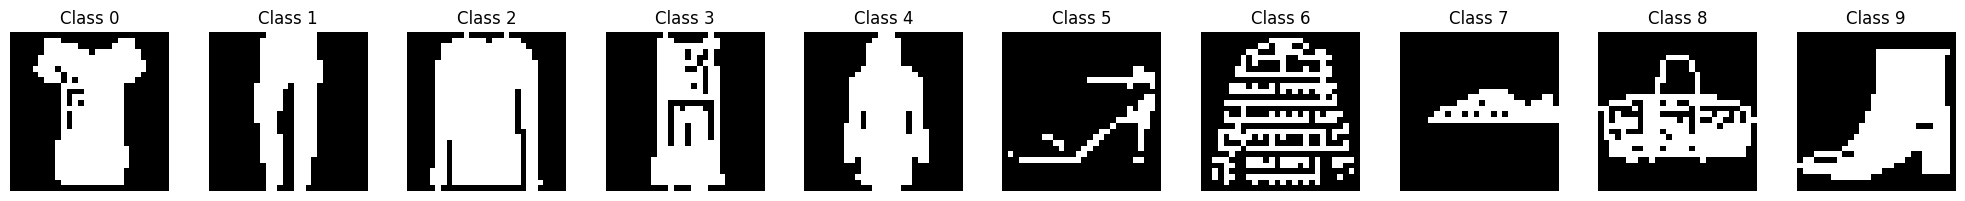

In [76]:
def show_one_sample_per_class(dataset, bpp=1, crop=False, max_classes=10):
    
    shape = (20, 20) if crop else (28, 28)
    
    # We will store one image for each class index from 0..9
    chosen_images = [None] * max_classes
    chosen_labels = set()

    # We can shuffle the dataset indices to pick random examples
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    for idx in all_indices:
        image, label = dataset[idx]
        if label < max_classes and chosen_images[label] is None:
            # Convert to numpy 
            image_np = np.array(image)
            
            reshaped = np.array([
                np.sum([
                    image_np[(j * bpp) + p] * (2 ** (bpp - p + 1)) 
                    for p in range(bpp)
                ]) 
                for j in range(shape[0] * shape[0])
            ]).reshape(shape)

            chosen_images[label] = reshaped
            chosen_labels.add(label)

        # Once we have found an example for every label, we can stop
        if len(chosen_labels) == max_classes:
            break

    # Plot
    fig, axes = plt.subplots(1, max_classes, figsize=(2 * max_classes, 2))
    for i in range(max_classes):
        axes[i].imshow(chosen_images[i], cmap='gray')
        axes[i].set_title(f"Class {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_one_sample_per_class(train_dataset, bpp=1, crop=False)

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

def show_random_samples_for_each_digit(train_class_loaders, shape=(28,28)):
    """
    Displays one random sample from each digit (0..9).
    """

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    
    for digit in range(10):
        digit_dataset = train_class_loaders[digit].dataset
        dataset_size = len(digit_dataset)

        # Pick a random index, fetch the image
        random_index = random.randint(0, dataset_size - 1)
        image, label = digit_dataset[random_index]

        # If image is bpp=1, shape is (28,28) or (20,20), 
        # but might also be [1,28,28]. If so, do .squeeze(0).
        if image.ndim == 3:
            image = image.squeeze(0)
        
        axes[digit].imshow(image.reshape(shape), cmap='gray')
        axes[digit].axis('off')
        axes[digit].set_title(f'Digit {digit}')

    plt.tight_layout()
    plt.show()


In [122]:
# run forward pass and collect activations for each digit's dataset
def run_and_collect_activations(model, train_class_loaders):
    
    for digit, loader in train_class_loaders.items():
        hooks = []  
        
        for idx, layer in enumerate(model.logic_layers):
            if isinstance(layer, LogicLayer): 
                # register hook for the current layer and digit
                hook = layer.register_forward_hook(
                    (lambda layer_idx, digit: 
                        lambda module, input, output: 
                            hook_fn(module, input, output, layer_idx, digit))(idx, digit)
                )
                hooks.append(hook)

        # runs forward pass for each batch in the DataLoader for the current digit
        for batch_data, _ in loader:
            model(batch_data)

        # unhook all the registered hooks after the forward pass
        for hook in hooks:
            hook.remove()

# passes trained diff logic model and all digit loaders
run_and_collect_activations(model, train_class_loaders)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [133]:
# calculation given two inputs (a and b) and their logic gate (i)
def bin_op(a, b, i):
    assert a[0].shape == b[0].shape, (a[0].shape, b[0].shape)
    if a.shape[0] > 1:
        assert a[1].shape == b[1].shape, (a[1].shape, b[1].shape)

    if i == 0:
        return torch.zeros_like(a)
    elif i == 1:
        return a * b
    elif i == 2:
        return a - a * b
    elif i == 3:
        return a
    elif i == 4:
        return b - a * b
    elif i == 5:
        return b
    elif i == 6:
        return a + b - 2 * a * b
    elif i == 7:
        return a + b - a * b
    elif i == 8:
        return 1 - (a + b - a * b)
    elif i == 9:
        return 1 - (a + b - 2 * a * b)
    elif i == 10:
        return 1 - b
    elif i == 11:
        return 1 - b + a * b
    elif i == 12:
        return 1 - a
    elif i == 13:
        return 1 - a + a * b
    elif i == 14:
        return 1 - a * b
    elif i == 15:
        return torch.ones_like(a)